# 4.- Train

In [8]:
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Load your dataset
df = pd.read_csv("../data/processed/features.csv").drop(['Date'], axis=1)
df

,Abs Extrema Duration,Low Threshold Count,Max Between Min,Pattern Extrema Duration,Min Deviation,Min Mean,Label
0,0.700000,0.033333,False,0.100000,0.383745,0.262343,0.0
1,0.366667,0.033333,False,0.200000,0.483459,0.382396,0.0
2,0.700000,0.066667,True,0.066667,0.012333,0.008721,1.0
3,0.466667,0.066667,True,0.133333,0.385687,0.087807,0.0
4,0.566667,0.000000,False,0.066667,0.083906,0.480007,0.0
...,...,...,...,...,...,...,...
98,0.466667,0.066667,True,0.100000,0.318943,0.047218,1.0
99,0.566667,0.033333,False,0.066667,0.338186,0.149486,1.0
100,0.733333,0.033333,False,0.133333,0.282234,0.105815,0.0
101,0.166667,0.100000,True,0.233333,0.272872,0.009114,1.0


In [3]:
label_df = df['Label']
features_df = df.drop('Label', axis=1)
features_df

,Abs Extrema Duration,Low Threshold Count,Max Between Min,Pattern Extrema Duration,Min Deviation,Min Mean
0,0.700000,0.033333,False,0.100000,0.383745,0.262343
1,0.366667,0.033333,False,0.200000,0.483459,0.382396
2,0.700000,0.066667,True,0.066667,0.012333,0.008721
3,0.466667,0.066667,True,0.133333,0.385687,0.087807
4,0.566667,0.000000,False,0.066667,0.083906,0.480007
...,...,...,...,...,...,...
98,0.466667,0.066667,True,0.100000,0.318943,0.047218
99,0.566667,0.033333,False,0.066667,0.338186,0.149486
100,0.733333,0.033333,False,0.133333,0.282234,0.105815
101,0.166667,0.100000,True,0.233333,0.272872,0.009114


In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_df,
                                                    label_df,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=df['Label'])

In [29]:
columns_with_outliers = ['Low Threshold Count']
columns_without_outliers = ['Abs Extrema Duration', 'Pattern Extrema Duration', 'Max Between Min', 'Min Deviation', 'Min Mean']


scalers = [
    ColumnTransformer([
        ('robust_scaler', PowerTransformer(method='yeo-johnson'), columns_with_outliers),
        ('standard_scaler', StandardScaler(), columns_without_outliers),
    ]),
    ColumnTransformer([
        ('robust_scaler', RobustScaler(), columns_with_outliers),
        ('minmax_scaler', MinMaxScaler(), columns_without_outliers),
    ]),
    ColumnTransformer([
        ('standard_scaler', StandardScaler(), columns_with_outliers + columns_without_outliers)
    ])
]

param_grid = [
    {
        'scalers': scalers,
        'model': [RandomForestClassifier()],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10],
    },
    {
        'scalers': scalers,
        'model': [GradientBoostingClassifier()],
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    {
        'scalers': scalers,
        'model': [SVC()],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    }
]

pipeline = Pipeline([
    ('scalers', scalers[1]),
    ('model', RandomForestClassifier())
])


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

best_pipeline = grid_search.best_estimator_
best_scaler = best_pipeline.named_steps['scalers']
best_model = best_pipeline.named_steps['model']

Best Parameters: {'model': SVC(), 'model__C': 10, 'model__kernel': 'linear', 'scalers': ColumnTransformer(transformers=[('robust_scaler', PowerTransformer(),
                                 ['Low Threshold Count']),
                                ('standard_scaler', StandardScaler(),
                                 ['Abs Extrema Duration',
                                  'Pattern Extrema Duration', 'Max Between Min',
                                  'Min Deviation', 'Min Mean'])])}
Best Cross-Validation Score: 0.8055555555555555


Accuracy on test set: 0.7419

Classification Report:
               precision    recall  f1-score   support

   No Pattern       0.75      0.75      0.75        16
Double Bottom       0.73      0.73      0.73        15

     accuracy                           0.74        31
    macro avg       0.74      0.74      0.74        31
 weighted avg       0.74      0.74      0.74        31



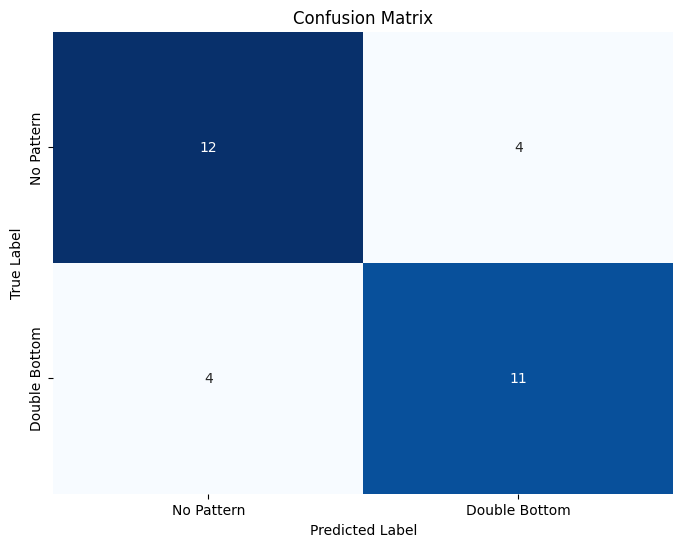

In [30]:
# Predict on the test set
X_test_scaled = best_scaler.transform(X_test)
y_pred = best_model.predict(X_test_scaled)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['No Pattern', 'Double Bottom'])
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the accuracy
print(f"Accuracy on test set: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Pattern', 'Double Bottom'], yticklabels=['No Pattern', 'Double Bottom'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

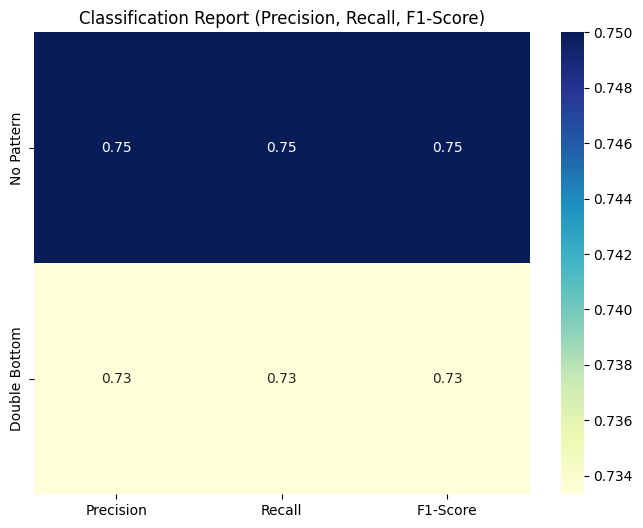

The best model does not provide feature importances.


c:\Users\walte\anaconda3\envs\double-bottom-detection-ml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


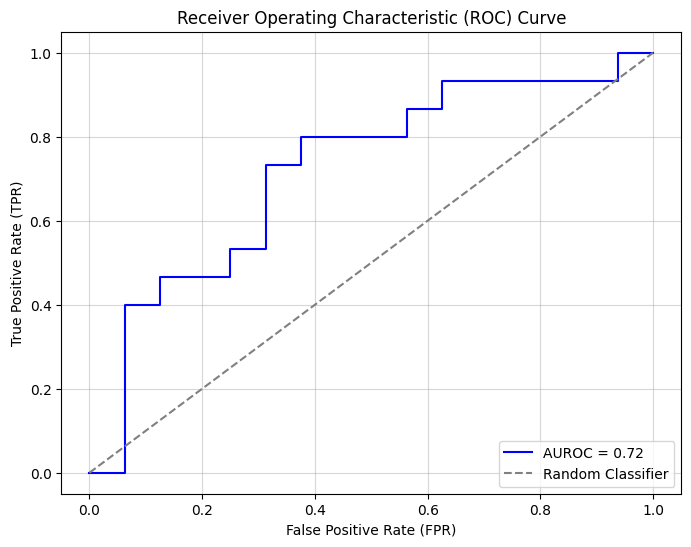

AUROC Score: 0.72


In [31]:
# Compute precision, recall, and f1-score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Create a DataFrame for heatmap
report_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=['No Pattern', 'Double Bottom'])

# Plot classification report as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap="YlGnBu", cbar=True, fmt='.2f')
plt.title("Classification Report (Precision, Recall, F1-Score)")
plt.show()

# Check if the best model supports feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    features = features_df.columns  # Ensure X_train is a DataFrame
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    # sns.barplot(x=feature_importances, y=features, palette='viridis')
    sns.barplot(x=feature_importances, y=features, palette='viridis', hue=features, legend=False)
    plt.title("Feature Importance - Best Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The best model does not provide feature importances.")

# Compute probabilities or decision function scores for AUROC
if hasattr(best_model, "predict_proba"):
    # For models supporting predict_proba
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    # For models like SVC without predict_proba
    y_pred_proba = best_model.decision_function(X_test)
else:
    raise AttributeError("The selected model does not support probability or decision function.")

# Compute ROC curve and AUROC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot the AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

print(f"AUROC Score: {auc_score:.2f}")
